# Multi-Layer Perceptron, MNIST

*   List item

*   List item

*   List item
*   List item


*   List item


*   List item


---
In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

Before we begin, we have to import the necessary libraries for working with data and PyTorch.

In [1]:
# import libraries
import torch
import numpy as np

---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

In [2]:
# The MNIST datasets are hosted on yann.lecun.com that has moved under CloudFlare protection
# Run this script to enable the datasets download
# Reference: https://github.com/pytorch/vision/issues/1938

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.dataset import random_split

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training validation and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
testing_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# Use random_split to create the validation and test set by using testing_data
val_data,test_data = random_split(testing_data,[0.5,0.5])


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 493kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.56MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.67MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
len(train_data)

60000

In [5]:
len(val_data)

5000

In [6]:
len(test_data)

5000

In [7]:
# prepare data loaders
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data,batch_size=batch_size, shuffle = True)
val_loader = DataLoader(val_data,batch_size=batch_size)
test_loader = DataLoader(test_data,batch_size=batch_size)

### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

(20, 1, 28, 28)


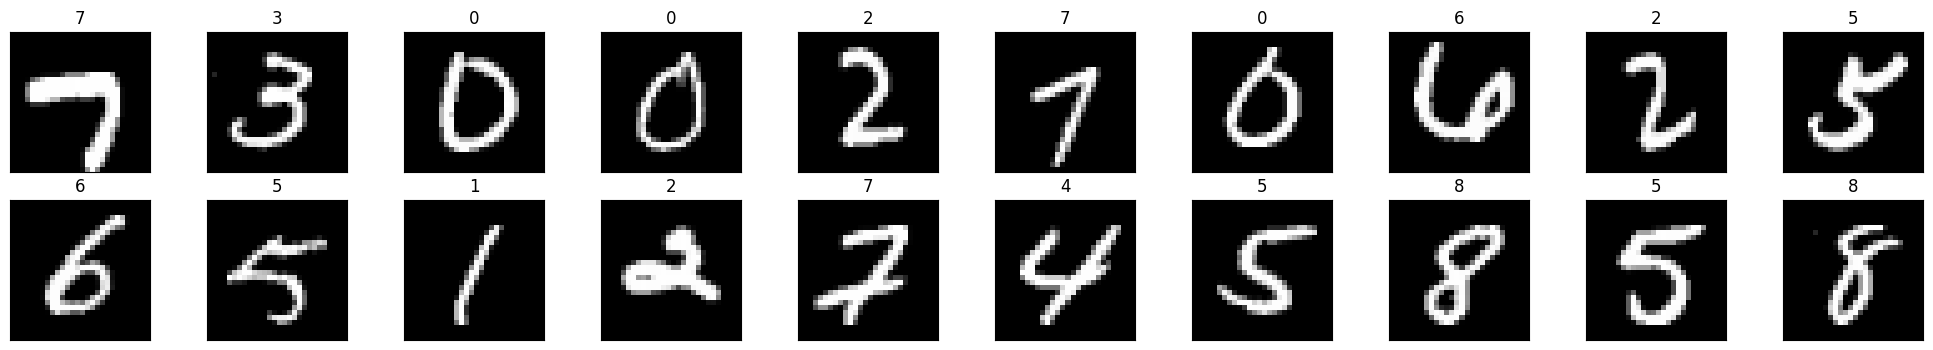

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.numpy()
print(images.shape)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail

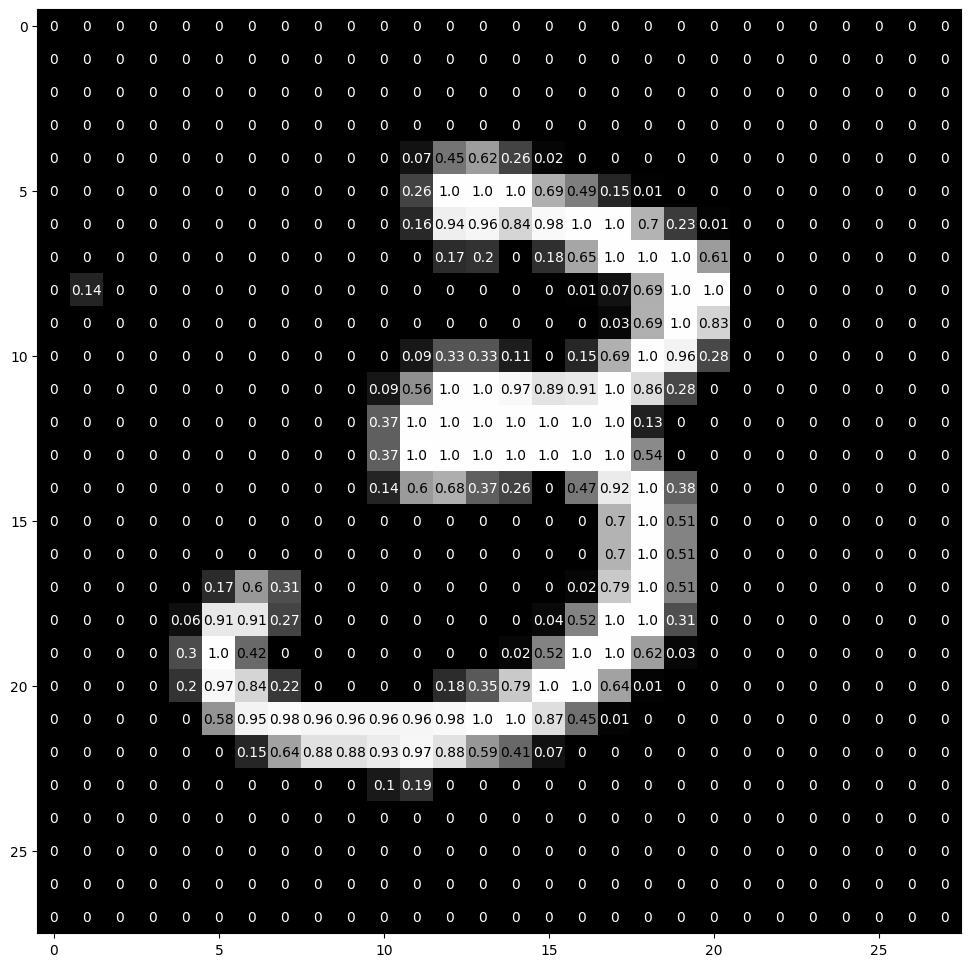

In [9]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.

In [10]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
## TODO: Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784,200)
        self.fc2 = nn.Linear(200,100)
        self.fc3 = nn.Linear(100,10)


    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer *and* then calculates the log loss.

In [11]:
## TODO: Specify loss (Cross Entropy Loss) and optimization functions

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(),lr=0.01)

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

The following loop trains for 30 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data.

In [12]:
def make_train_step_fn(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def perform_train_step_fn(x, y):
        # Sets model to TRAIN mode
        model.train()

        # Step 1 - Computes our model's predicted output - forward pass

        yhat = model(x)


        # Step 2 - Computes the loss

        loss = loss_fn(yhat,y)

        # Step 3 - Computes gradients for both "a" and "b" parameters
        loss.backward()
        # Step 4 - Updates parameters using gradients and the learning rate
        optimizer.step()
        optimizer.zero_grad()


        # Returns the loss
        return loss.item()

    # Returns the function that will be called inside the train loop
    return perform_train_step_fn

In [13]:
def mini_batch(device, data_loader, step_fn):
    mini_batch_losses = []
    for xbatch,ybatch in train_loader:
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"
        xbatch = xbatch.to(device)
        ybatch = ybatch.to(device)

        # Performs one train step and returns the corresponding loss
        # for this mini-batch
        mini_batch_loss = step_fn(xbatch,ybatch)
        mini_batch_losses.append(mini_batch_loss)

    # Computes average loss over all mini-batches - that's the epoch loss
    loss = np.mean(mini_batch_losses)
    return loss

In [14]:
def make_val_step_fn(model, loss_fn):
    # Builds function that performs a step in the validation loop
    def perform_val_step_fn(x, y):
        # Sets model to EVAL mode
        model.eval()

        # Step 1 - Computes our model's predicted output - forward pass
        yhat = model(x)
        # Step 2 - Computes the loss
        loss = loss_fn(yhat,y)
        # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
        return loss.item()

    return perform_val_step_fn

In [15]:
#%%writefile model_training/v5.py

# Defines number of epochs
n_epochs = 10
model = model.to(device)
# Lists to keep track of losses
losses = []
val_losses = []
val_step_fn = make_val_step_fn(model, criterion)
train_step_fn = make_train_step_fn(model, criterion,optimizer)
for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)

    # VALIDATION
    # no gradients in validation!
    with torch.no_grad():
        val_loss = mini_batch(device, val_loader, val_step_fn)
        val_losses.append(val_loss)

    # Records both losses for each epoch under the main tag "loss"
    #writer.add_scalars(main_tag='loss',
    #                   tag_scalar_dict={'training': loss, 'validation': val_loss},
    #                   global_step=epoch)

# Closes the writer
#writer.close()



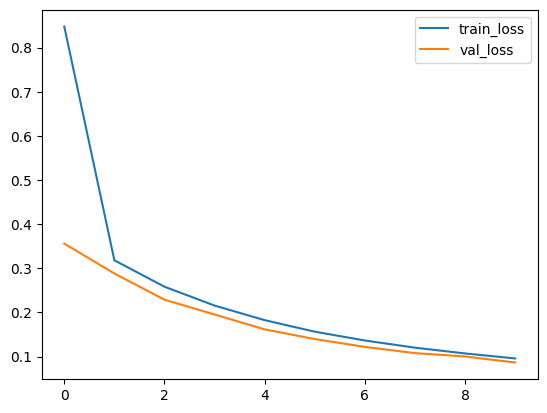

In [16]:
from matplotlib import pyplot as plt
plt.plot(losses)
plt.plot(val_losses)
plt.legend(['train_loss','val_loss'])
plt.show()

---
## Test the Trained Network

Finally, we test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

#### `model.eval()`

`model.eval(`) will set all the layers in your model to evaluation mode. This affects layers like dropout layers that turn "off" nodes during training with some probability, but should allow every node to be "on" for evaluation!

In [17]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    data, target = data.to(device), target.to(device)
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            class_correct[i], class_total[i]))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.107271

Test Accuracy of     0: 97% (491/502)
Test Accuracy of     1: 98% (583/589)
Test Accuracy of     2: 96% (502/522)
Test Accuracy of     3: 96% (490/508)
Test Accuracy of     4: 96% (434/448)
Test Accuracy of     5: 94% (424/449)
Test Accuracy of     6: 98% (463/470)
Test Accuracy of     7: 97% (504/518)
Test Accuracy of     8: 95% (464/484)
Test Accuracy of     9: 94% (481/510)

Test Accuracy (Overall): 96% (4836/5000)


### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

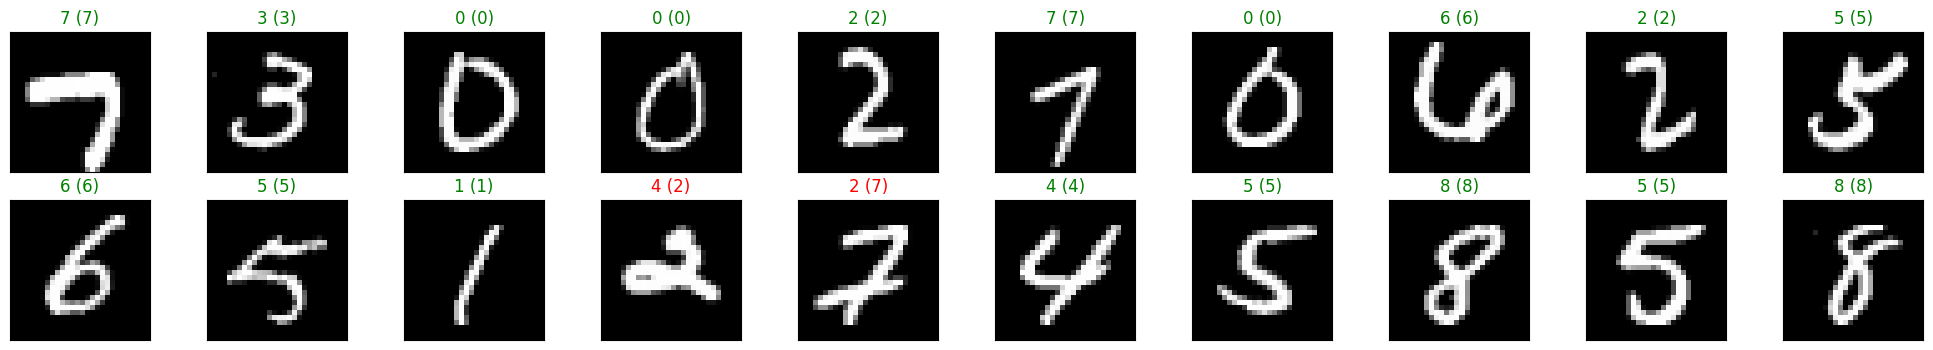

In [18]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images,labels = images.to(device),labels.to(device)
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))